# Main

___
## Imports

In [1]:
import numpy as np
import os
from collections import Counter


from utils.load import download_flickr, download_glove, load_data, load_split_dataset
from utils.explore import (
    get_descriptive_statistics,
    explore_dataset,
    visualize_image,
    get_captions,
)
from utils.split import split_and_save_data
from utils.preprocessing import get_vocabulary, resize_image_dictionary, pad_images

import tensorflow as tf
from keras.applications.inception_v3 import (
    InceptionV3,
    preprocess_input,
    decode_predictions,
)
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Input, Dropout, Dense, Embedding, LSTM, MaxPooling2D, Conv2D, add

from utils.model import ImageCaptioningModel

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset



c:\Users\justi\Desktop\CS\Cours\3A\deep-learning\image-caption-generator\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


___
## Global Variables

In [2]:
image_folder = "data/Images"
image_folder_homogeneous = "data/Images_homogeneous"
captions_file = "data/captions.txt"
split_data = "data/split_dataset"

___
## Downloading the Dataset

If not already done

In [3]:
if not os.path.exists("data/Image"):
    download_flickr()

Path to dataset files: C:\Users\justi\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1
Operation cancelled.


___
## Exploring the Dataset

Valid if the dataset has already been loaded into your `data` folder.

Number of images: 8091
Max width: 500, Min width: 164, Mean width: 457.87220368310466
Max height: 500, Min height: 127, Mean height: 397.25188481028306


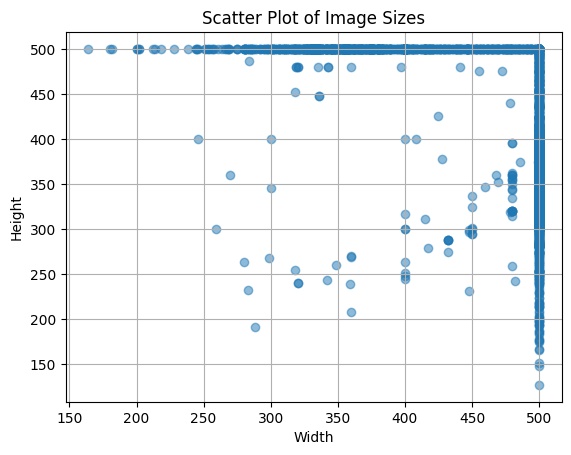

In [4]:
get_descriptive_statistics(image_folder)

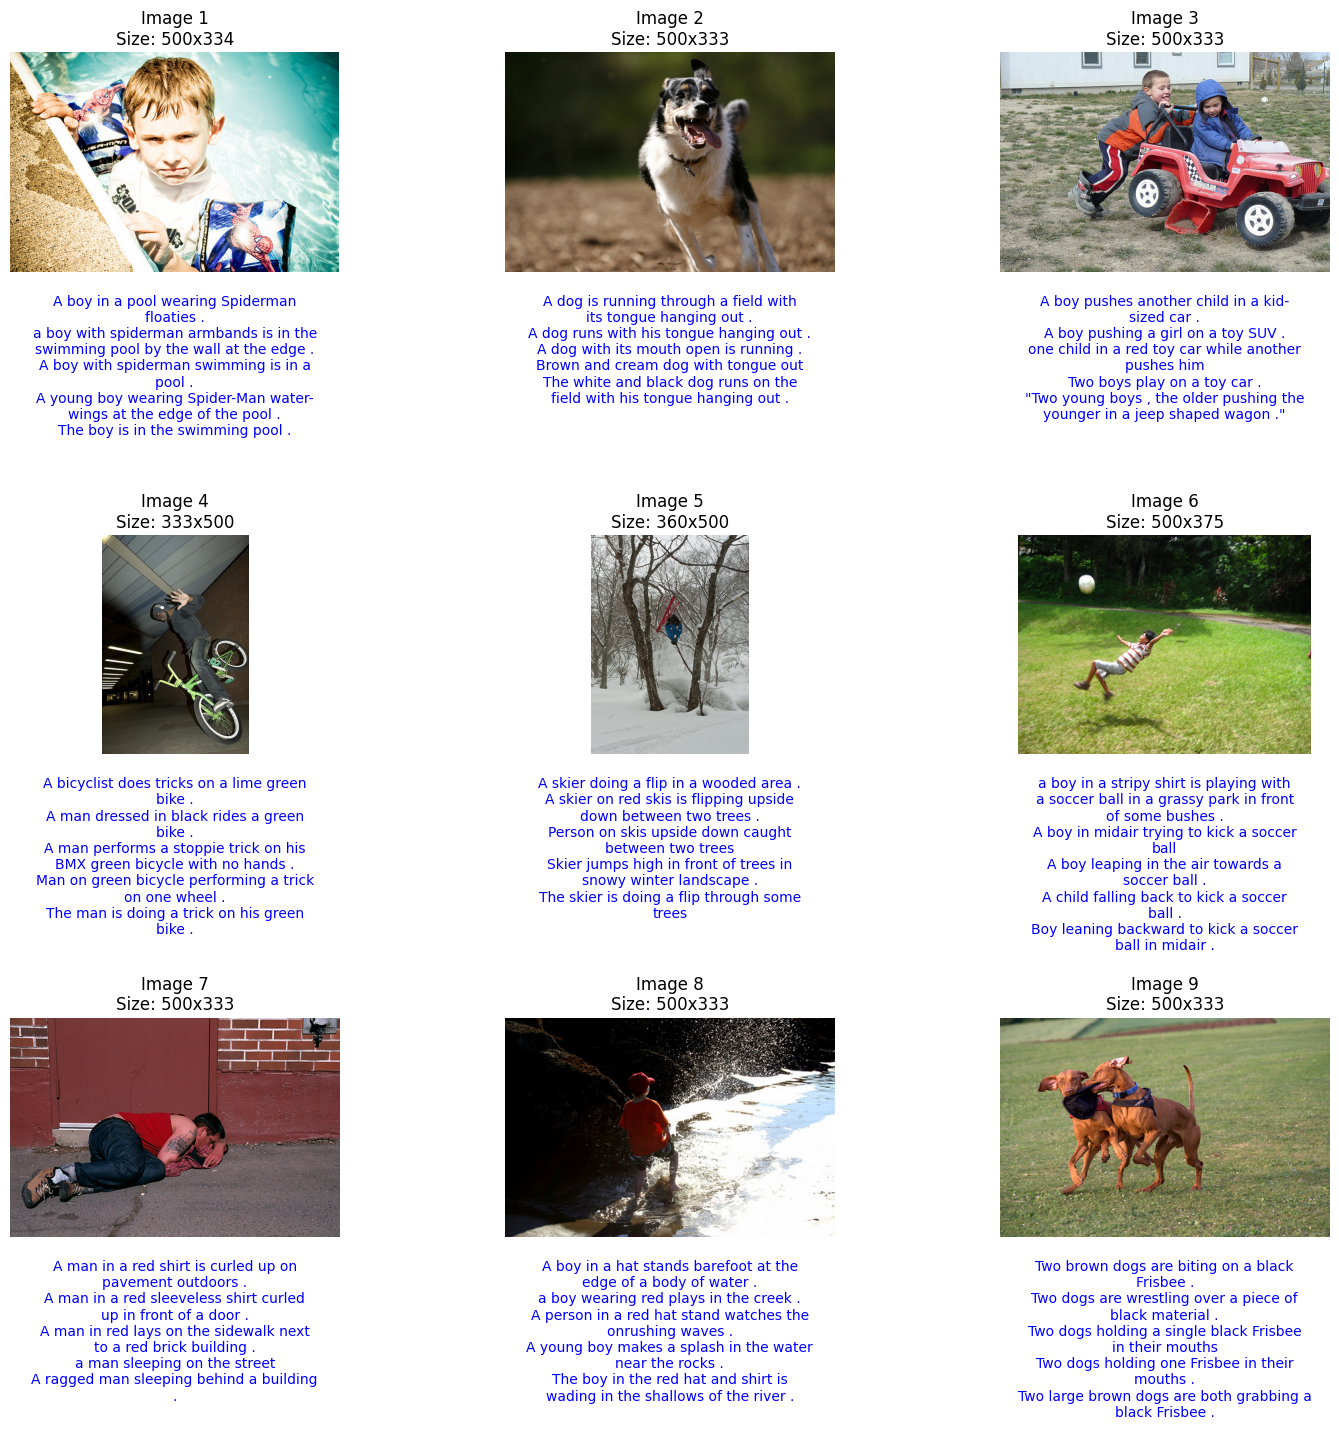

In [5]:
explore_dataset(image_folder, captions_file)

___
## Loading the Data

In [6]:
# adding padding so that all images have the same dimensions
if not os.path.exists(image_folder_homogeneous):
    pad_images(image_folder, image_folder_homogeneous, target_size=(500, 500))

In [7]:
image_arrays, image_captions = load_data(image_folder_homogeneous, captions_file)

In [8]:
print(type(image_arrays), type(image_captions))

<class 'dict'> <class 'dict'>


### Cleaning the Captions

We exploring the `data/captions.txt` file, we notice that the captions seem to end with a `.`, so let's just remove this to have cleaner captions.

In [9]:
image_captions = {
    img_name: [cap.replace('.', '').strip().lower() for cap in captions]
    for img_name, captions in image_captions.items()
}

### Creating the Vocabulary

The vocabulary contains all the unique words present in the captions.

In [10]:
vocabulary = get_vocabulary(image_captions)

___
## Splitting the Dataset

In [11]:
train_data, val_data, test_data, train_captions, val_captions, test_captions = split_and_save_data(image_arrays, image_captions, save_folderpath=split_data)

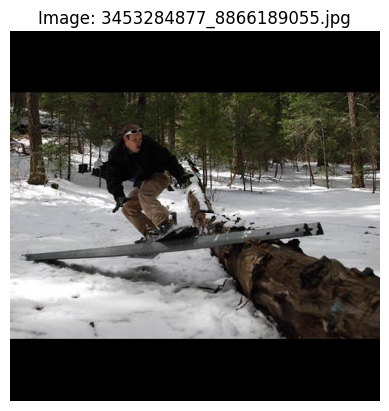

['a guy is grinding a rail over a tree on his snowboard', 'a man snowboarding making a jump off a steel guardrail', 'a snowboarder grinding up a homemade ramp', 'a snowboarder is riding his board on ramp made from a piece of metal and a log', 'the man is skateboarding over a log in the snow']


In [12]:
i = 129
visualize_image(train_data, i)
print(
    get_captions(train_captions, i)
)

___
## Extracting a Feature Vector from each image

We can extract the main features of an image with a pre-trained model, which has been trained in a large dataset. This way we can get from each image a vector containing the main characteristics of this image. We will use the **InceptionV3** model.

In [13]:
def get_ith_value(dict, i):
    return list(dict.values())[i]

In [14]:
base_model = InceptionV3(weights="imagenet")
model = Model(base_model.input, base_model.layers[-2].output)


def encode_images(
    img_dict: dict, model: Model = model, batch_size: int = 32
) -> dict[str, np.ndarray]:
    print("resizing the images...")
    resized_images = resize_image_dictionary(img_dict, (299, 299))
    feature_vectors = {}
    print("extracting the feature vectors...")
    img_names = list(resized_images.keys())
    img_arrays = list(resized_images.values())
    # preprocessing all images
    img_arrays = [preprocess_input(img_array) for img_array in img_arrays]

    batch_number = 0
    for start_index in range(0, len(img_names), batch_size):
        if batch_number % 10 == 0:
            print(f"batch number {batch_number}")
        end_index = min(start_index + batch_size, len(img_names))
        batch_images = img_arrays[start_index:end_index]
        batch_names = img_names[start_index:end_index]
        # predicting the feature vectors for the batch
        batch_vectors = model.predict(np.array(batch_images))
        # reshaping and storing the feature vectors
        for i, img_name in enumerate(batch_names):
            vec = np.reshape(batch_vectors[i], (batch_vectors.shape[1]))
            feature_vectors[img_name] = vec
        batch_number += 1
        
    return feature_vectors


fea_vec_train = encode_images(train_data)

print(fea_vec_train)
print(len(list(train_data.values())), len(fea_vec_train.values()))

resizing the images...
extracting the feature vectors...
batch number 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
batch number 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
batch number 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/s

___
## Tokenization of the Vocabulary

We need to tokenize our vocabulary to make it understandable for a neural network.

In [15]:
min_apparitions = 10  # defining a threshold of number of apparitions in the text.

text = " ".join(
    [" ".join(train_captions[img_name]) for img_name in list(train_captions.keys())]
)
# doit-on mettre les 3 dict captions ou non ?

words = text.split(" ")

# this returns a dictionary containing the words and the number of their occurrences in the text
words_count = Counter(words)

# keeping just the important words
important_words = [
    word for word, n_occ in words_count.items() if n_occ >= min_apparitions
]

# mapping the words to integers
int_to_word = {i: word for i, word in enumerate(important_words)}
word_to_int = {word: i for i, word in enumerate(important_words)}

vocabulary_size = len(list(int_to_word.keys()))
print(vocabulary_size)

# find the maximum length of a description in a dataset
max_length = max(
    [
        max([len(caption.split(" ")) for caption in captions])
        for captions in list(train_captions.values())
    ]
)
print(max_length)

1749
37


___
## Vector Embeddings

In [16]:
if not os.path.exists("data/glove"):
    download_glove()

In [17]:
# resizing for computation
target_size = (128, 128)
train_data = resize_image_dictionary(train_data, target_size)
val_data = resize_image_dictionary(val_data, target_size)
test_data = resize_image_dictionary(test_data, target_size)

In [18]:
X1, X2, y = [], [], []

for img_name, caps in train_captions.items():
    img_array = train_data[img_name]

    for cap in caps:
        sequence = [word_to_int[word] for word in cap.split(" ") if word in word_to_int]

        for i in range(1, len(sequence)):
            input_sequence = sequence[:i]
            output_sequence = sequence[i]

            input_sequence = pad_sequences([input_sequence], maxlen=max_length)[0]
            output_sequence = to_categorical(
                [output_sequence], num_classes=vocabulary_size
            )[0]

            X1.append(img_array)
            X2.append(input_sequence)
            y.append(output_sequence)

X2 = np.array(X2)
X1 = np.array(X1)
y = np.array(y)


# load glove vectors for embedding layer
embeddings_index = {}
glove_path = "data/glove/glove.6B.200d.txt"
glove = open(glove_path, "r", encoding="utf-8").read()
for line in glove.split("\n"):
    values = line.split(" ")
    word = values[0]
    if word != '':
        indices = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = indices



In [19]:
embedding_dim = 200
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
print(embedding_matrix.shape)
for word, i in word_to_int.items():
    if word != '' and word in embeddings_index:
        embedding_vector = embeddings_index[word]
        if embedding_vector is not None and embedding_vector.shape != (0,):
            embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(1749, 200)


(1749, 200)

___
## Defining the Model

In [20]:
tensorflow_ = 0
pytorch_ = 1

In [21]:
if tensorflow_:
    input_1 = Input(shape=(target_size[0], target_size[1], 3))

    # Add convolutional layers for feature extraction
    conv_1 = Conv2D(64, (3, 3), activation='relu')(input_1)
    pool_1 = MaxPooling2D((2, 2))(conv_1)
    conv_2 = Conv2D(128, (3, 3), activation='relu')(pool_1)
    pool_2 = MaxPooling2D((2, 2))(conv_2)
    conv_3 = Conv2D(256, (3, 3), activation='relu')(pool_2)
    pool_3 = MaxPooling2D((2, 2))(conv_3)
    flattened_features = Flatten()(pool_3)

    # features_1 = Dropout(0.2)(input_1)
    features_1 = Dropout(0.2)(flattened_features)
    features_2 = Dense(256, activation="relu")(features_1)

    input_2 = Input(shape=(max_length,))
    sequence_1 = Embedding(vocabulary_size, embedding_dim, mask_zero=True)(input_2)
    sequence_2 = Dropout(0.2)(sequence_1)
    sequence_3 = LSTM(256)(sequence_2)

    decoder_1 = add([features_2, sequence_3])
    decoder_2 = Dense(256, activation="relu")(decoder_1)

    flattened_output = Flatten()(decoder_2)
    outputs = Dense(vocabulary_size, activation="softmax")(flattened_output)
    model = Model(inputs=[input_1, input_2], outputs=outputs)

    model.summary()

In [22]:
if pytorch_:
    model = ImageCaptioningModel(target_size, vocabulary_size, embedding_dim, max_length)

___
## Training the Model

In [23]:
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [28]:
batch_size = 64

In [29]:
if tensorflow_:
    for layer in model.layers:
        if isinstance(layer, Embedding):
            layer.set_weights([embedding_matrix])
            layer.trainable = False

    model.compile(loss="categorical_crossentropy", optimizer="adam")

    


    # data generator
    def data_generator(X1, X2, y, batch_size):
        num_samples = len(X1)
        while True:
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            for start in range(0, num_samples, batch_size):
                end = min(start + batch_size, num_samples)
                batch_indices = indices[start:end]
                x1_batch = X1[batch_indices]
                x2_batch = X2[batch_indices]
                y_batch = y[batch_indices]
                yield (x1_batch, x2_batch), y_batch


    train_generator = data_generator(X1, X2, y, batch_size)
    model.fit(train_generator, epochs=50, steps_per_epoch=len(X1) // batch_size)

In [30]:
if pytorch_:
    # Set the weights of the embedding layer
    embedding_matrix = np.random.rand(vocabulary_size, embedding_dim)  # Example embedding matrix
    model.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
    model.embedding.weight.requires_grad = False  # Freeze the embedding layer

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

In [31]:
if pytorch_:
    # Data generator
    class CustomDataset(Dataset):
        def __init__(self, X1, X2, y):
            self.X1 = X1
            self.X2 = X2
            self.y = y

        def __len__(self):
            return len(self.X1)

        def __getitem__(self, idx):
            return self.X1[idx], self.X2[idx], self.y[idx]

In [50]:
if pytorch_:
    dataset = CustomDataset(X1, X2, y)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    num_epochs = 50
    model.train() # set the model to training mode

    for epoch in range(num_epochs):
        for batch_idx, (x1_batch, x2_batch, y_batch) in enumerate(train_loader):
            x1_batch = x1_batch.clone().detach().to(torch.float32)
            if x1_batch.shape[1] != 3: # if the channel is at last index 
                x1_batch = x1_batch.permute(0, 3, 1, 2) # it should be
            x2_batch = x2_batch.clone().detach().to(torch.long)
            y_batch = y_batch.clone().detach().to(torch.float32)

            optimizer.zero_grad()
            outputs = model(x1_batch, x2_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    print("Training completed.")

Epoch [1/50], Step [1/4766], Loss: 23.0084
Epoch [1/50], Step [11/4766], Loss: 6.5928
Epoch [1/50], Step [21/4766], Loss: 5.6018
Epoch [1/50], Step [31/4766], Loss: 6.0060
Epoch [1/50], Step [41/4766], Loss: 5.2474
Epoch [1/50], Step [51/4766], Loss: 5.5962
Epoch [1/50], Step [61/4766], Loss: 5.7819
Epoch [1/50], Step [71/4766], Loss: 5.4064
Epoch [1/50], Step [81/4766], Loss: 5.1163
Epoch [1/50], Step [91/4766], Loss: 5.6217
Epoch [1/50], Step [101/4766], Loss: 6.3004
Epoch [1/50], Step [111/4766], Loss: 5.5985
Epoch [1/50], Step [121/4766], Loss: 5.3747
Epoch [1/50], Step [131/4766], Loss: 5.2274
Epoch [1/50], Step [141/4766], Loss: 5.1714
Epoch [1/50], Step [151/4766], Loss: 5.2830
Epoch [1/50], Step [161/4766], Loss: 4.9194
Epoch [1/50], Step [171/4766], Loss: 5.3365
Epoch [1/50], Step [181/4766], Loss: 4.9912
Epoch [1/50], Step [191/4766], Loss: 5.2171
Epoch [1/50], Step [201/4766], Loss: 4.9956
Epoch [1/50], Step [211/4766], Loss: 5.4359
Epoch [1/50], Step [221/4766], Loss: 5.181

KeyboardInterrupt: 

___
## Predicting the output

In [ ]:
def generate_caption(image_array: np.ndarray) -> str:
    start = "startseq"
    for i in range(max_length):
        sequence = [word_to_int[word] for word in start.split() if word in word_to_int]
        sequence = pad_sequences([sequence], maxlen=max_length)

        y_pred = model.predict([image_array, sequence])
        y_pred = np.argmax(y_pred)

        word = int_to_word[y_pred]
        start += ' ' + word
        if word == "endseq":
            break

    final = start.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

print("please test the model!")